# Conditioning and Guidance 4 - export cat guidance example

- Ok this one is a bit finnicky!
- I'm leaving part 3 as a reference example in case I need to recreate it carefully
- Dropping sigma max to 1 here, should keep an eye on that. 

In [1]:
torch_seed=2
N_sample=256 
sigma_max=10

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader
from smalldiffusion import TreeDataset, training_loop, samples, ScheduleLogLinear, ConditionalMLP
from torch.utils.data import Dataset
from itertools import pairwise
from pathlib import Path
from tqdm import tqdm

def plot_batch(batch, ax=None, **kwargs):
    batch = batch.cpu().numpy()
    ax = ax or plt
    return ax.scatter(batch[:,0], batch[:,1], marker='.', **kwargs)
    
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w   

class MultiClassSwissroll(Dataset):
    def __init__(self, tmin, tmax, N, num_classes=10, center=(0,0), scale=1.0):

        self.num_classes = num_classes
        
        t = tmin + torch.linspace(0, 1, N) * tmax
        center = torch.tensor(center).unsqueeze(0)
        spiral_points = center + scale * torch.stack([t*torch.cos(t)/tmax, t*torch.sin(t)/tmax]).T
        
        # Assign classes based on position along the spiral
        # Divide the parameter range into num_classes segments
        class_boundaries = torch.linspace(tmin, tmax, num_classes + 1)
        classes = torch.zeros(N, dtype=torch.long)
        
        for i in range(N):
            # t[i] is already the actual parameter value we want to use for class assignment
            t_val = t[i]
            # Find which segment t_val falls into (0 to num_classes-1)
            class_idx = min(int((t_val - tmin) / (tmax - tmin) * num_classes), num_classes - 1)
            classes[i] = class_idx
        
        # Store data as list of (point, class) tuples
        self.data = [(spiral_points[i], classes[i].item()) for i in range(N)]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def get_class_colors(self):
        """
        Returns a list of colors evenly sampled from a colorwheel (HSV space).
        """
        import matplotlib.colors as mcolors
        
        # Generate evenly spaced hues around the color wheel
        hues = np.linspace(0, 1, self.num_classes, endpoint=False)
        colors = []
        
        for hue in hues:
            # Convert HSV to RGB (saturation=1, value=1 for vibrant colors)
            rgb = mcolors.hsv_to_rgb([hue, 1.0, 1.0])
            colors.append(rgb)
        
        return colors


In [3]:
dataset = MultiClassSwissroll(np.pi/2, 5*np.pi, 100, num_classes=3)
colors = dataset.get_class_colors()
loader = DataLoader(dataset, batch_size=len(dataset)*2, shuffle=True)

In [4]:
x, labels = next(iter(loader))
x=x.cpu().numpy()

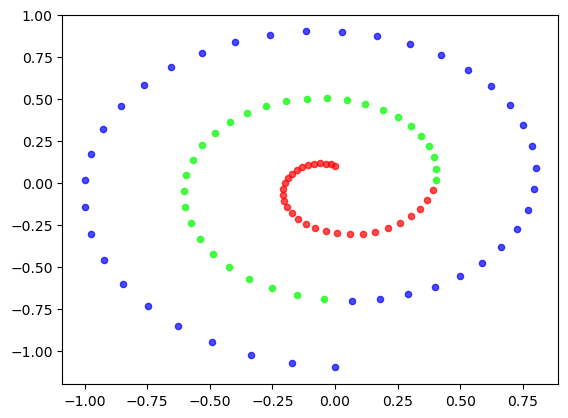

In [5]:
for class_idx in range(dataset.num_classes):
    mask = labels == class_idx
    class_points = x[mask]
    plt.scatter(class_points[:, 0], class_points[:, 1], 
               c=[colors[class_idx]], label=f'Class {class_idx}', 
               alpha=0.7, s=20)

In [6]:
torch.manual_seed(torch_seed)
model = ConditionalMLP(dim=2, hidden_dims=(16, 128, 256, 128, 16), cond_dim=4, num_classes=dataset.num_classes)
schedule = ScheduleLogLinear(N=N_sample, sigma_min=0.01, sigma_max=sigma_max) #Changing sigma max here, revert if I can find a good example. 
trainer = training_loop(loader, model, schedule, epochs=30000, lr=1e-3, conditional=True)
losses = [ns.loss.item() for ns in trainer]

100%|█████████████████████████████████████| 30000/30000 [04:34<00:00, 109.12it/s]


In [7]:
torch.save(model, '/home/stephen/sora/jun_27_1.pt')

In [21]:
bound=2.0
num_heatmap_steps=64
grid=[]
for i, x in enumerate(np.linspace(-bound, bound, num_heatmap_steps)):
    for j, y in enumerate(np.linspace(-bound, bound, num_heatmap_steps)):
        grid.append([x,y])
grid=torch.tensor(grid).float()

In [22]:
# Generalizes most commonly-used samplers:
#   DDPM       : gam=1, mu=0.5
#   DDIM       : gam=1, mu=0
#   Accelerated: gam=2, mu=0

torch.manual_seed(torch_seed)
sample_batch_size=128
gam=1.0
cfg_scale=0.0 # 0 means no classifier-free guidance
mu=0.0
batchsize=sample_batch_size

results_by_class=[]
xt_history=[]
heatmaps=[]
unconditioned_heatmaps=[]
conditioned_heatmaps=[]
cfg_scales=[0.0, 0.1, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0]
c=2 #Just hack on a single class for now

sigmas=schedule.sample_sigmas(N_sample)
x_init = model.rand_input(batchsize).to('cuda') * sigmas[0]

for cfg_scale in cfg_scales:
    cond=torch.tensor([c for _ in range(sample_batch_size)])
    cond_grid=torch.tensor([c for _ in range(len(grid))])
    xt_history.append([])
    heatmaps.append([])
    unconditioned_heatmaps.append([])
    conditioned_heatmaps.append([])
    with torch.no_grad():
        model.eval()
        # xt = model.rand_input(batchsize).to('cuda') * sigmas[0]
        xt=x_init.clone()
        if cond is not None:
            assert cond.shape[0] == xt.shape[0], 'cond must have same shape as x!'
            cond = cond.to(xt.device)
        eps = None
        for i, (sig, sig_prev) in enumerate(pairwise(sigmas)):
            eps_prev, eps = eps, model.predict_eps_cfg(xt, sig.to(xt), cond, cfg_scale)
            eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
            sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu)
            eta = (sig_prev**2 - sig_p**2).sqrt()
            xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)
            
            xt_history[-1].append(xt.cpu().numpy())
            # heatmaps[-1].append(model.forward(grid, sig.to('cuda'), cond=cond))
            heatmaps[-1].append(model.predict_eps_cfg(grid.to('cuda'), sig.to(xt), cond_grid.to('cuda'), cfg_scale).cpu())

            #Uncoditioned and conditioned heatmaps let's go!
            uncond = torch.full_like(cond_grid.to('cuda'), model.cond_embed.null_cond) # (B,)
            eps_cond, eps_uncond = model.predict_eps(                  # (B,), (B,)
                torch.cat([grid.to('cuda'), grid.to('cuda')]), sig.to(xt), torch.cat([cond_grid.to('cuda'), uncond])   # (2B,)
            ).chunk(2)
            unconditioned_heatmaps[-1].append(eps_uncond.cpu())
            conditioned_heatmaps[-1].append(eps_cond.cpu())

    xt_history[-1]=np.array(xt_history[-1])
    results_by_class.append(xt.cpu().numpy())
xt_history=np.array(xt_history)
# heatmaps=np.array(heatmaps)

In [23]:
np.save('/home/stephen/sora/conditioned_history_5.npy', xt_history)
np.save('/home/stephen/sora/conditioned_heatmaps_5.npy', np.array(heatmaps))
np.save('/home/stephen/sora/conditioned_heatmaps_5u.npy', np.array(unconditioned_heatmaps))
np.save('/home/stephen/sora/conditioned_heatmaps_5c.npy', np.array(conditioned_heatmaps))

In [20]:
cond

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')

In [24]:
colors24 = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'gray', 'pink', 'olive', 'cyan', 'magenta', 'black', 'aqua',  'yellow', 'navy', 'maroon', 'lime', 'teal', 'silver', 'fuchsia', 'indigo', 'crimson', 'gold', 'coral']

In [25]:
save_dir=Path('/home/stephen/sora/jun_27_1')
save_dir.mkdir(exist_ok=True)

In [26]:
heatmap_mask=np.zeros((30,30), dtype=bool)
heatmap_mask[10:20, 10:20]=1.0

In [27]:
xt_history.shape

(8, 256, 128, 2)

<Figure size 640x480 with 0 Axes>

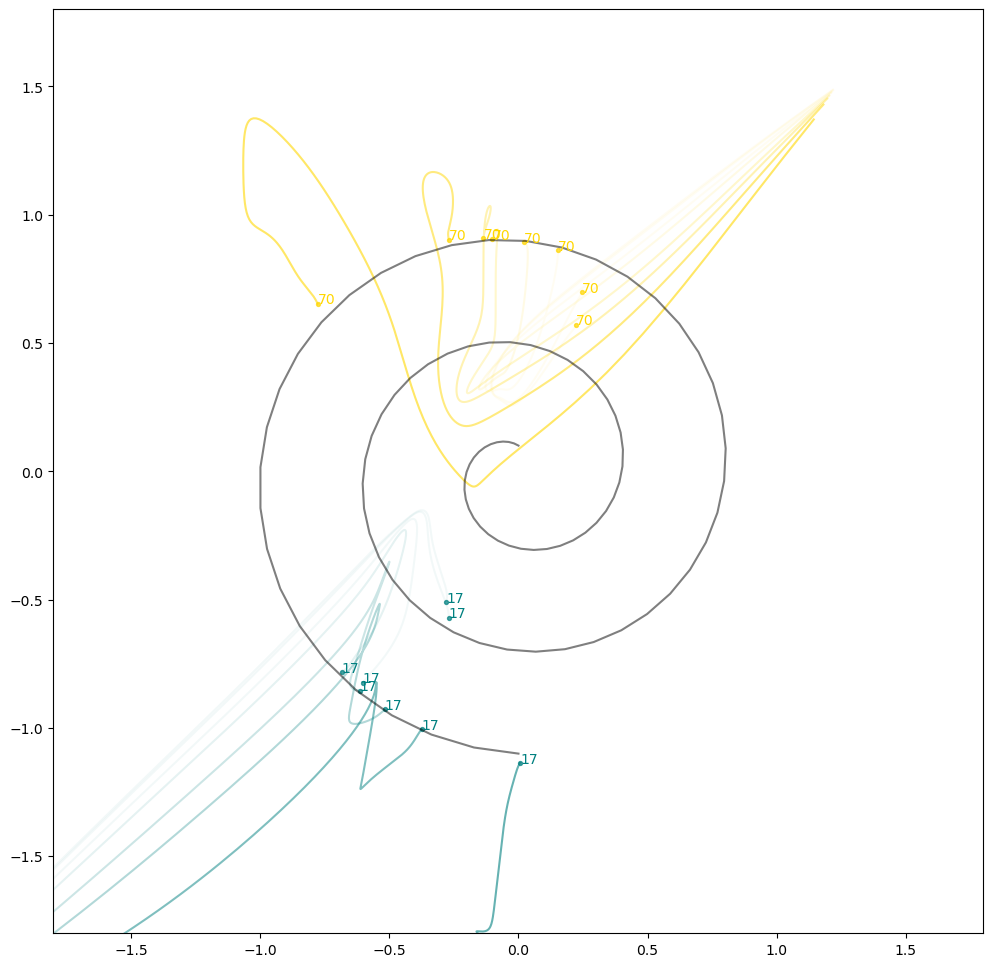

In [28]:
#Let's try different guidance levels sequentiall first.
count=0
# for i in tqdm(range(len(heatmaps[0]))):
i=255
plt.clf()
fig=plt.figure(0, (12,12))

for j, cfg_scale in enumerate(cfg_scales):
    masked_map=torch.nn.functional.normalize(heatmaps[j][i], p=2, dim=1)
    # heatmap_norm=heatmaps[j][i] #*heatmap_mask
    # masked_map=(heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
    # masked_map=masked_map.view(900,2)
    # plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=40, color='g')

    masked_map=torch.nn.functional.normalize(unconditioned_heatmaps[j][i], p=2, dim=1)
    # heatmap_norm=unconditioned_heatmaps[j][i] #*heatmap_mask
    # masked_map=(unconditioned_heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
    # masked_map=masked_map.view(900,2)
    # plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=40, color='#777777')

    masked_map=torch.nn.functional.normalize(conditioned_heatmaps[j][i], p=2, dim=1)
    # heatmap_norm=conditioned_heatmaps[j][i] #*heatmap_mask
    # masked_map=(conditioned_heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
    # masked_map=masked_map.view(900,2)
    # plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=40, color='m')

    for k in [17, 70]: #range(128): #17 or 70 seem like good candidates - lets make 70 plan A
        # plt.plot(xt_history[j][np.maximum(i-10, 0):i+1,k,0], xt_history[j][np.maximum(i-10, 0):i+1,k,1], '-', alpha=0.2, color=tuple(colors[c]))
        plt.plot(xt_history[j][:i+1,k,0], xt_history[j][:i+1,k,1], '-', alpha=np.clip(cfg_scale/10, 0.05, 0.6), color=colors24[k%24])
        plt.scatter(xt_history[j][i,k,0], xt_history[j][i,k,1], alpha=0.7, s=8, c=colors24[k%24])
        plt.text(xt_history[j][i,k,0], xt_history[j][i,k,1], str(k), color=colors24[k%24])

data_raw=np.array([o[0].numpy() for o in dataset.data])
plt.plot(data_raw[:,0], data_raw[:,1], c='k', alpha=0.5)

viz_bounds=1.8
plt.xlim([-viz_bounds, viz_bounds]);  plt.ylim([-viz_bounds, viz_bounds])
plt.savefig(save_dir/(str(count)+'.png'), dpi=200)
count+=1

/tmp/ipykernel_45559/773835901.py:6: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0, (12,12))
100%|██████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]


<Figure size 640x480 with 0 Axes>

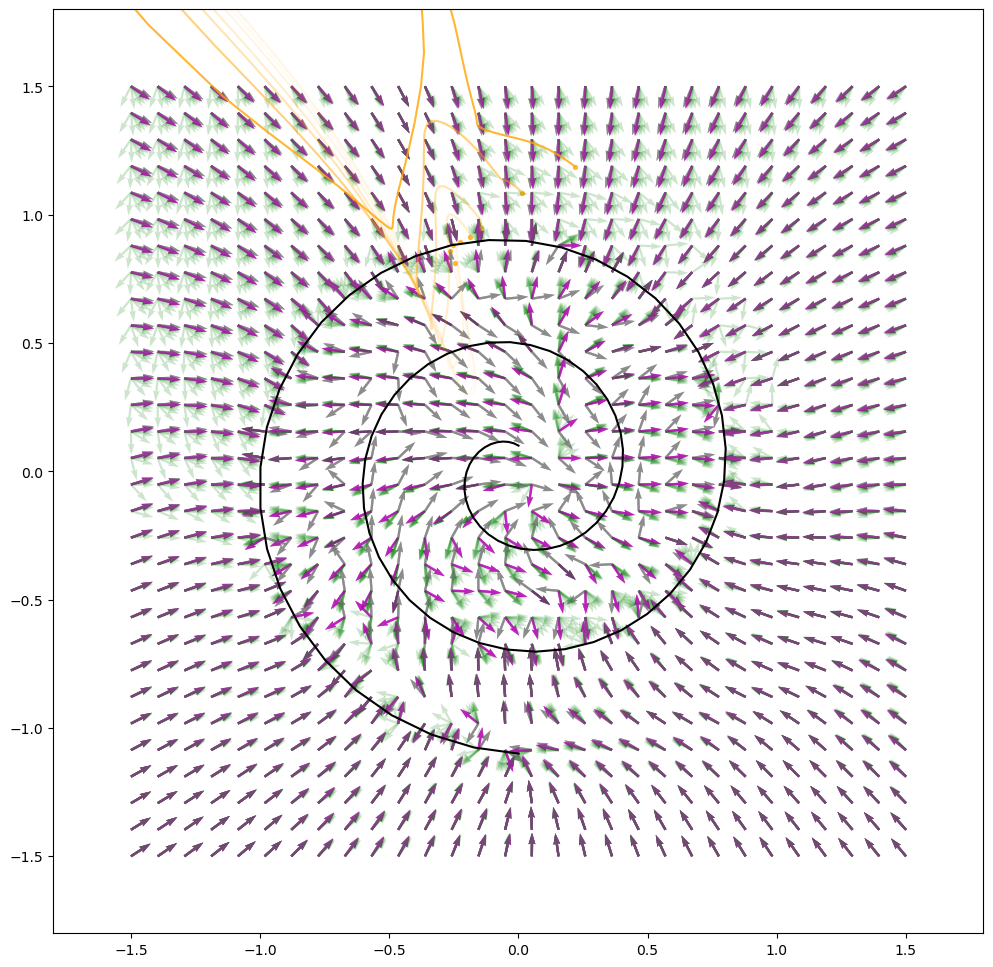

In [107]:
#Let's try different guidance levels sequentiall first.
count=0
for i in tqdm(range(len(heatmaps[0]))):
# i=25
    plt.clf()
    fig=plt.figure(0, (12,12))

    for j, cfg_scale in enumerate(cfg_scales):
        masked_map=torch.nn.functional.normalize(heatmaps[j][i], p=2, dim=1)
        # heatmap_norm=heatmaps[j][i] #*heatmap_mask
        # masked_map=(heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
        # masked_map=masked_map.view(900,2)
        plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=40, color='g')
    
        masked_map=torch.nn.functional.normalize(unconditioned_heatmaps[j][i], p=2, dim=1)
        # heatmap_norm=unconditioned_heatmaps[j][i] #*heatmap_mask
        # masked_map=(unconditioned_heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
        # masked_map=masked_map.view(900,2)
        plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=40, color='#777777')
    
        masked_map=torch.nn.functional.normalize(conditioned_heatmaps[j][i], p=2, dim=1)
        # heatmap_norm=conditioned_heatmaps[j][i] #*heatmap_mask
        # masked_map=(conditioned_heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
        # masked_map=masked_map.view(900,2)
        plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=40, color='m')
    
        for k in [75]: #range(75, 80): #Just do a subset of trajetories
            # plt.plot(xt_history[j][np.maximum(i-10, 0):i+1,k,0], xt_history[j][np.maximum(i-10, 0):i+1,k,1], '-', alpha=0.2, color=tuple(colors[c]))
            plt.plot(xt_history[j][:i+1,k,0], xt_history[j][:i+1,k,1], '-', alpha=np.clip(cfg_scale/10, 0.05, 0.8), color=colors24[k%24])
            plt.scatter(xt_history[j][i,k,0], xt_history[j][i,k,1], alpha=0.7, s=8, c=colors24[k%24])
    
    data_raw=np.array([o[0].numpy() for o in dataset.data])
    plt.plot(data_raw[:,0], data_raw[:,1], c='k')
    
    viz_bounds=1.8
    plt.xlim([-viz_bounds, viz_bounds]);  plt.ylim([-viz_bounds, viz_bounds])
    plt.savefig(save_dir/(str(count)+'.png'), dpi=200)
    count+=1

<Figure size 640x480 with 0 Axes>

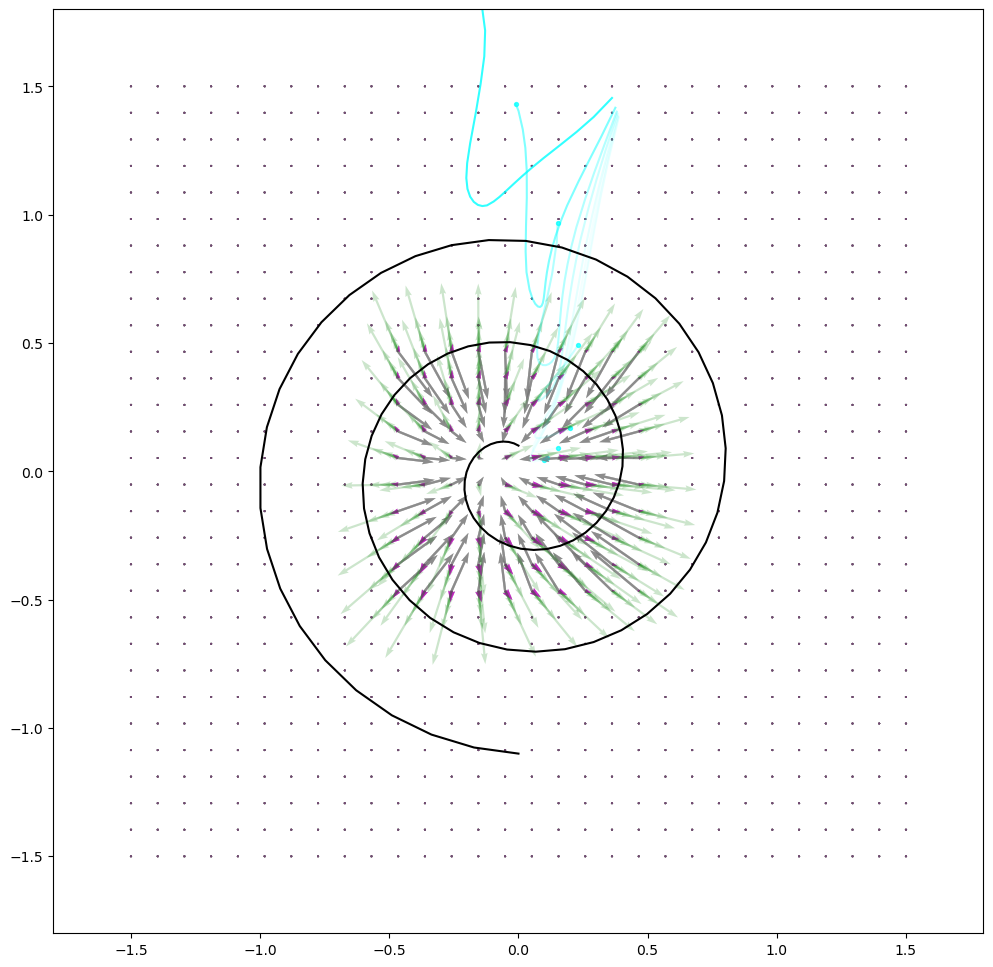

In [92]:
#Let's try different guidance levels sequentiall first.
count=0
# for i in tqdm(range(len(heatmaps[0]))):
i=28
plt.clf()
fig=plt.figure(0, (12,12))

for j, cfg_scale in enumerate(cfg_scales):
    # heatmap_norm=torch.nn.functional.normalize(heatmaps[j][i], p=2, dim=1)
    # heatmap_norm=heatmaps[j][i] #*heatmap_mask
    masked_map=(heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
    masked_map=masked_map.view(900,2)
    plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=120, color='g')

    # heatmap_norm=torch.nn.functional.normalize(unconditioned_heatmaps[j][i], p=2, dim=1)
    # heatmap_norm=unconditioned_heatmaps[j][i] #*heatmap_mask
    masked_map=(unconditioned_heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
    masked_map=masked_map.view(900,2)
    plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=10, color='#777777')

    # heatmap_norm=torch.nn.functional.normalize(conditioned_heatmaps[j][i], p=2, dim=1)
    # heatmap_norm=conditioned_heatmaps[j][i] #*heatmap_mask
    masked_map=(conditioned_heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
    masked_map=masked_map.view(900,2)
    plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=40, color='m')

    for k in [60]: #range(60,64): #Just do a subset of trajetories
        # plt.plot(xt_history[j][np.maximum(i-10, 0):i+1,k,0], xt_history[j][np.maximum(i-10, 0):i+1,k,1], '-', alpha=0.2, color=tuple(colors[c]))
        plt.plot(xt_history[j][:i+1,k,0], xt_history[j][:i+1,k,1], '-', alpha=np.clip(cfg_scale/10, 0.05, 0.8), color=colors24[k%24])
        plt.scatter(xt_history[j][i,k,0], xt_history[j][i,k,1], alpha=0.7, s=8, c=colors24[k%24])

data_raw=np.array([o[0].numpy() for o in dataset.data])
plt.plot(data_raw[:,0], data_raw[:,1], c='k')

viz_bounds=1.8
plt.xlim([-viz_bounds, viz_bounds]);  plt.ylim([-viz_bounds, viz_bounds])
plt.savefig(save_dir/(str(count)+'.png'), dpi=200)
count+=1

Ok I think intex 60 could be nice -> let me explort the vector field now. 